# Задание 2
## RSI индикатор
### Щелыкалов Виктор

**Цель работы:** исследовать подход к разработке торговых стратегий на основе технического индикатора RSI(Индекс относительной силы)

**Задачи:**
1. Рассмотреть индикатор RSI и его область применения;
2. Реализовать торговую стратегию на основе индикатора RSI;
3. Реализовать торговую стратегию на основе тех. индикаторов с применением метода МО;
4. Сделать выводы об эффективности данных подходов.

**Описание решения:**
В данном блокноте представлены две торговые стратегии.
Первая - базовая, торгует на основании определения перекупленности/перепроданности с помощью индикатора [RSI](https://www.investopedia.com/terms/r/rsi.asp). Были выбраные наиболее распространенные трешхолды входа и выхода из позиции:
- больше 70 - продаем
- меньше 30 - покупаем

Вторая - с применением бустинга. Данные были размечены на шаг вперед, т.е. торговая итерация составляем 5 минут. Решается задачи классификации, в качестве фичей используются наборы технических индикаторов. Набор был выбран произвольно.

**Заключение:**
Получить положительный PnL с учетом комиссии не удалось ни при одном из описанных подходов. Более того, в ходе бэктестирования мы покупали и продавали по мидпрайсу - что невозможно в реальном мире.

Однако без учета комиссии, удается получить прибыльную торговую стратегию, что указывает на возможность дальнейшей развитии данного подхода.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [51]:
def rsi(df, periods = 14, ema = True):
    close_delta = df['BTCUSDT'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

<Axes: title={'center': 'BTCUSDT 1m close price'}, xlabel='time'>

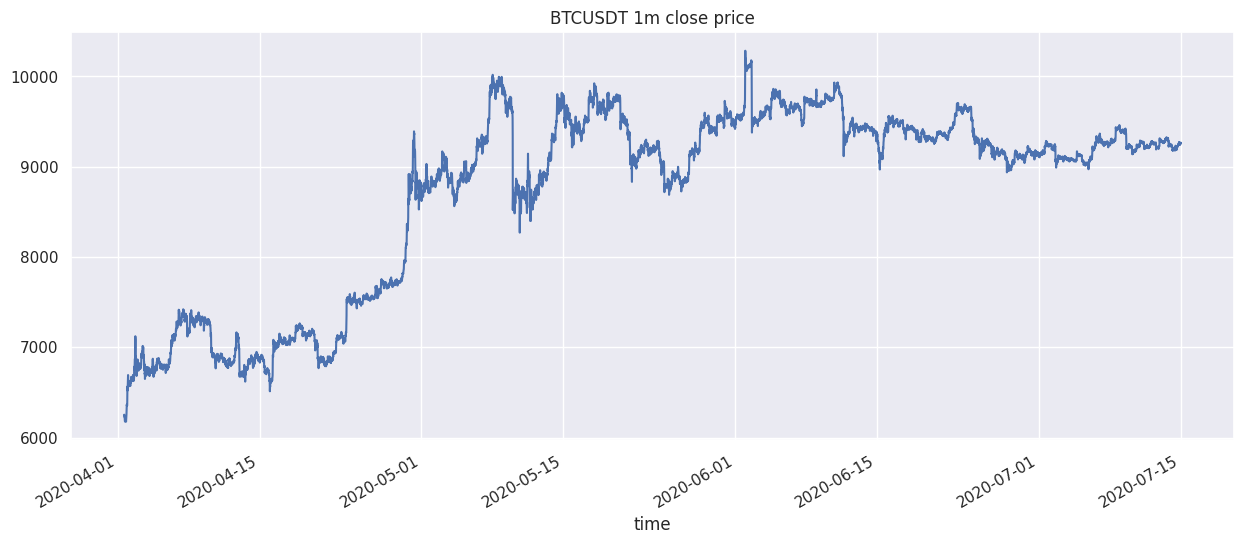

In [52]:
df = pd.read_csv('cryptoPrices15_wNB.csv')
df = df[['time','BTCUSDT']]
df = df[-10000:]
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='ms')
plt.figure(figsize=(15,6))
df['BTCUSDT'].plot(title='BTCUSDT 1m close price')

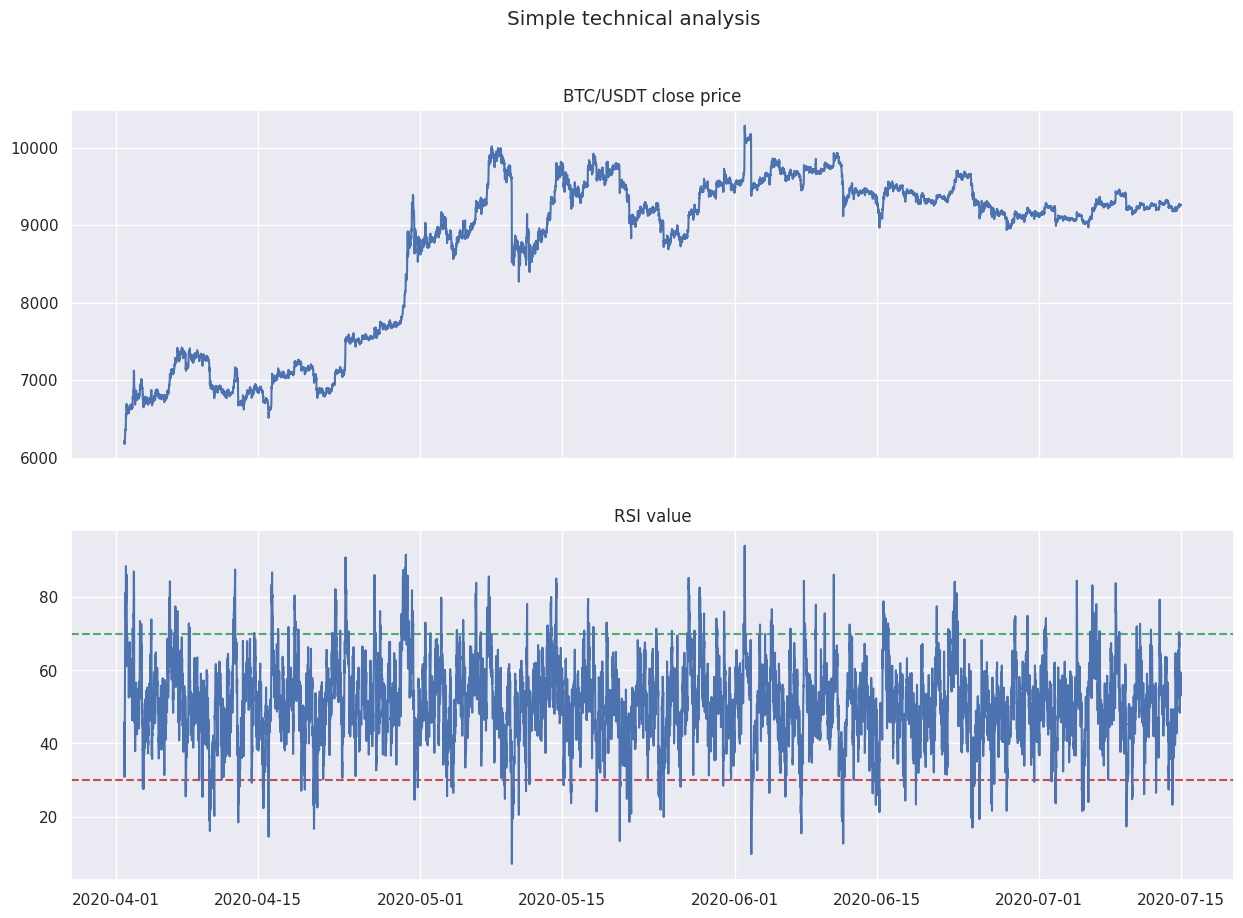

In [53]:
df['rsi'] = rsi(df)
df = df.dropna()

fig, ax = plt.subplots(2, sharex=True, figsize=(15,10))
fig.suptitle('Simple technical analysis')

ax[0].set_title('BTC/USDT close price')
ax[0].plot(df.index, df['BTCUSDT'])

ax[1].set_title('RSI value')
ax[1].axhline(y=70, color='g', linestyle='--', label='Oversold (30)')
plt.axhline(y=30, color='r', linestyle='--', label='Overbought (70)')
ax[1].plot(df.index, df['rsi'])

In [54]:
def generate_signals(rsi_values):
    signals = []
    for rsi in rsi_values:
        if rsi < 70:
            signals.append(1) # BUY тренд наверх
        elif rsi > 30:
            signals.append(-1) # SELL тренд вниз
        else:
            signals.append(0) # HOLD стагнация рынка, не можем определиться
    return signals

<Axes: title={'center': 'Signals'}, xlabel='time'>

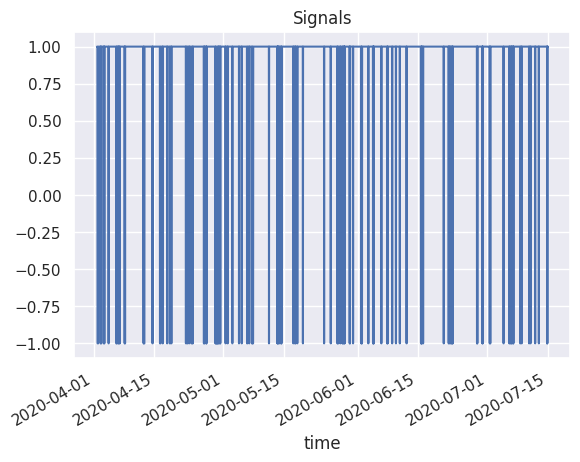

In [55]:
df['signal'] = generate_signals(df['rsi'])
plt.title('Signals')
df['signal'].plot()

In [190]:
def backtest(df, signal_column='signal_pred', show_result=True,  fee=0.0):
    actual_ask = df['BTCUSDT'].loc[df.index] # считаем, что покупаем по мидпрайсу
    actual_bid = df['BTCUSDT'].loc[df.index] # считаем, что продаем по мидпрайсу

    # Матричная реализация - существенно быстрее наивной
    # Использовал при прогнозировании на 100ms
    # df['returns'] = actual_ask.pct_change().shift(-1)
    # df['pos'] = df[signal_column].replace(0,np.nan).ffill()

    # df.loc[df['pos'] == -1, 'returns'] = 0
    # cur_fee = df['pos'].diff().abs() * fee + (df['pos'].diff() < 0) * ((actual_ask - actual_bid) / actual_ask)
    # df['cum_returns'] = (df['returns'] + 1 - cur_fee).cumprod()

    #  Наивная реализация
    df['returns'] = 1
    buy_price = 0
    in_pos = 0
    for index, row in df.iterrows():
        if row[signal_column] == 1 and in_pos == 0:
            buy_price = actual_ask[index]
            in_pos=1
        elif row[signal_column] == -1 and in_pos == 1:
            sell_price = actual_bid[index]
            df.at[index, 'returns'] =  1 + (sell_price * (1-fee) - buy_price * (1+fee)) / buy_price
            in_pos = 0
    df['cum_returns'] = df['returns'].cumprod()

    if show_result:
        show_backtest_result(df, signal_column)
    return df


def show_backtest_result(df, signal_column='signal_pred'):
    fig, ax = plt.subplots(3, sharex=True, figsize=(15,10))

    # plot daily trades count with 20-trades line
    trades_per_day = df[df[signal_column] != 0][signal_column].rolling(2).sum().fillna(0).groupby(df[df[signal_column] != 0].index.date).apply(lambda x: (x==0).sum())
    ax[0].plot(trades_per_day)
    ax[0].axhline(y=20,linewidth=1, color='r', ls='--', label='mininal 20 trades in a day')
    ax[0].set_title('Trades per day')
    ax[0].set_ylabel('Trades count')
    ax[0].legend()

    # plot cum_returns with ideal case
    ax[1].plot(df.index, df['cum_returns'])
    ax[1].set_ylabel('Returns')
    ax[1].set_title('Cumulative returns')

    # plot drawdown
    ax[2].plot(df.index, df['cum_returns'].expanding().max() - df['cum_returns'])
    ax[2].set_ylabel('Fraction')
    ax[2].set_title('Drawdown')
    ax[2].set_xlabel('Date')


    print(f'Total trades count = {trades_per_day.sum()}')
    print(f"Max drawdown = {(df['cum_returns'].expanding().max() - df['cum_returns']).max() * 100}%")
    print(f'Average trades count per day = {trades_per_day.mean()}')
    print(f"Average return per day = {(df['returns'] - 1).groupby(df.index.date).sum().mean() * 100}%")
    print(f"Average return per closing pos = {(df[(df[signal_column] == -1) & (df['returns'] != 0)]['returns'] - 1).mean()*100}%")

Total trades count = 251
Average trades count per day = 2.3679245283018866
Average return per day = 9420.965389272218%
Average return per closing pos = 100.04761463295307%


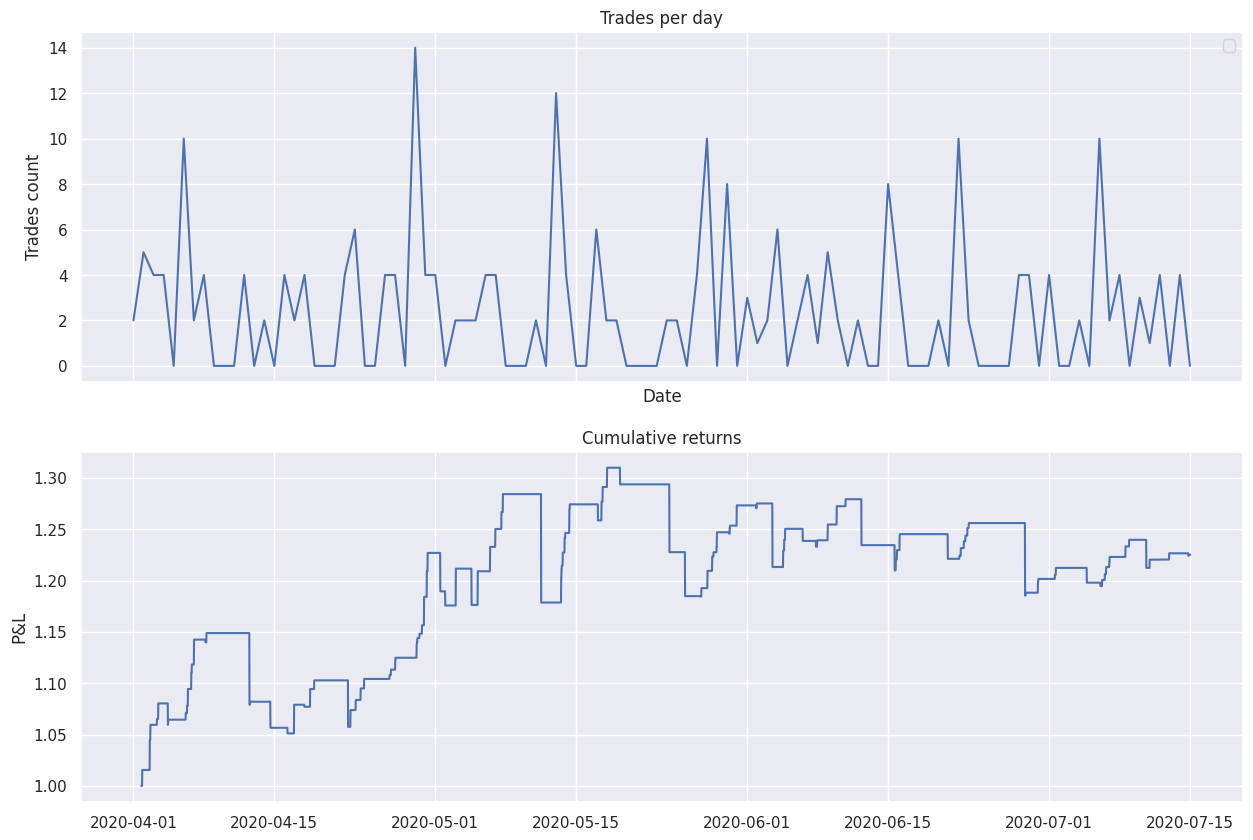

In [57]:
# without fee
df = backtest(df=df, signal_column='signal', fee = 0)

Total trades count = 251
Average trades count per day = 2.3679245283018866
Average return per day = 9420.729329543321%
Average return per closing pos = 99.99426211426892%


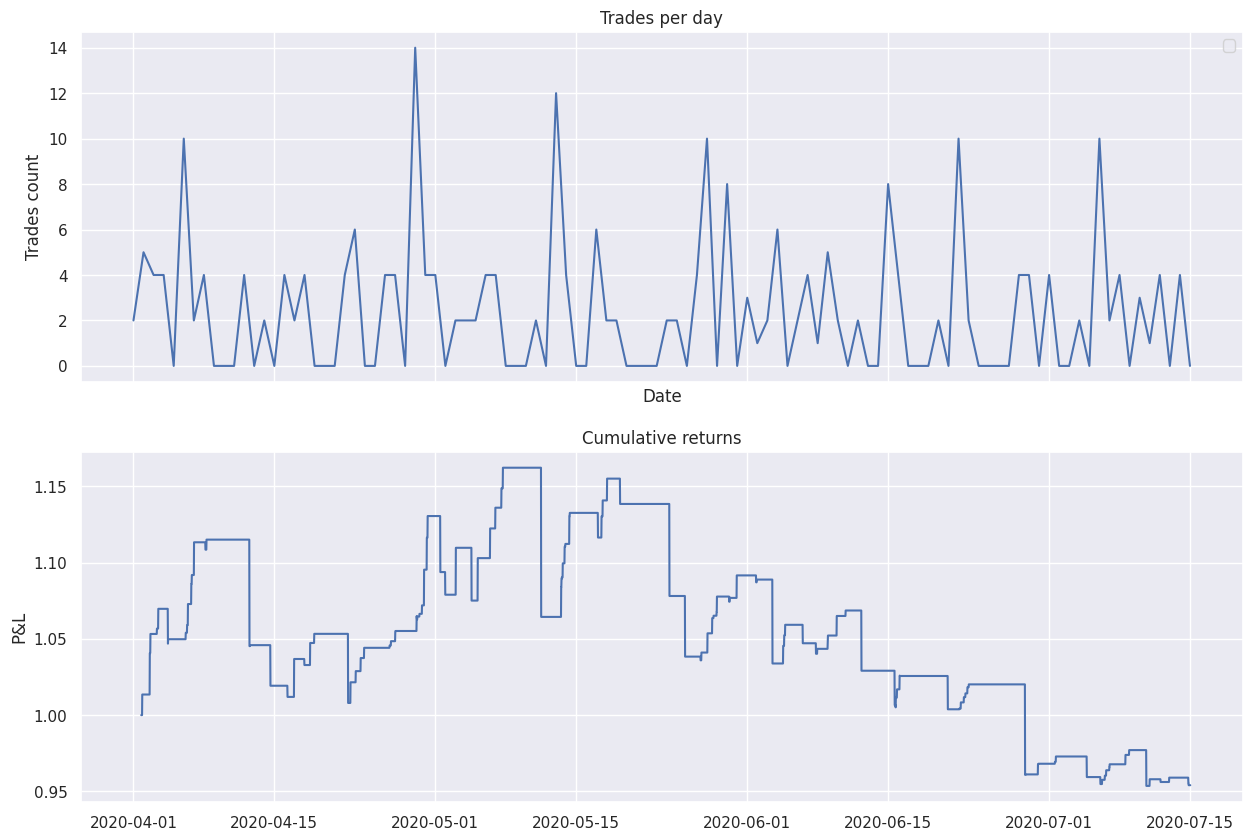

In [58]:
# with fee
df = backtest(df=df, signal_column='signal', fee = 0.001)

# WL approach

In [ ]:
!pip install pandas-ta

In [74]:
import pandas_ta as ta
import lightgbm as lgb # берем именно эту реализацию, потому что она легкая и быстрая
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

In [75]:
def calc_features(df):
  df['macd'] = ta.macd(df['BTCUSDT'])['MACD_12_26_9'].values

  df.ta.bbands(close='BTCUSDT', length=10, append=True)
  df.ta.bbands(close='BTCUSDT', length=50, append=True)
  df.ta.bbands(close='BTCUSDT', length=100, append=True)


  df['ema10'] = ta.ema(df['BTCUSDT'], 10).values
  df['ema50'] = ta.ema(df['BTCUSDT'], 50).values
  df['ema100'] = ta.ema(df['BTCUSDT'], 100).values

  df['zscore10'] = ta.zscore(df['BTCUSDT'], 10).values
  df['zscore50'] = ta.zscore(df['BTCUSDT'], 50).values
  df['zscore100'] = ta.zscore(df['BTCUSDT'], 100).values

  df['rvi'] = ta.zscore(df['BTCUSDT']).values
  return df.dropna()

In [76]:
df = calc_features(df)

In [77]:
df.head()

,BTCUSDT,rsi,signal,returns,cum_returns,macd,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,...,BBB_100_2.0,BBP_100_2.0,ema10,ema50,ema100,zscore10,zscore50,zscore100,rvi,future_delta1_midprice
time,,,,,,,,,,,,,,,,,,,,,
2020-04-04 20:45:00,6789.11,53.695063,1,1.000000,1.080628,8.896160,6719.286707,6774.972,6830.657293,1.643853,...,2.413008,0.747165,6778.954970,6760.898384,6748.859100,0.481724,0.522209,0.983703,0.995789,0.005490
2020-04-04 21:00:00,6826.38,58.997062,1,1.000000,1.080628,12.164788,6715.362277,6778.906,6842.449723,1.874749,...,2.453247,0.964659,6787.577702,6763.466290,6750.394167,1.417537,1.242614,1.849320,2.006943,0.001584
2020-04-04 21:15:00,6837.19,60.412911,1,1.000000,1.080628,15.449385,6712.476482,6784.932,6857.387518,2.135777,...,2.500686,1.016471,6796.598120,6766.357416,6752.112897,1.368461,1.401351,2.055530,2.080222,0.005444
2020-04-04 21:30:00,6874.41,64.906231,-1,1.010552,1.092030,20.815842,6705.980327,6795.202,6884.423673,2.626020,...,2.599386,1.203607,6810.745735,6770.594772,6754.534622,1.684418,2.016963,2.800322,2.666040,-0.002213
2020-04-04 21:45:00,6859.20,61.818295,0,1.000000,1.092030,23.569780,6705.188292,6802.123,6899.057708,2.850131,...,2.675322,1.094048,6819.555601,6774.069487,6756.607203,1.117206,1.640213,2.364283,2.056045,0.000159


In [78]:
# Трешхолд был подобран руками, однако при наличии ресурсов я бы предпочел оптимизировать его(например sccipy'ем)
threshold = 0.001

def set_target(df):
    df['signal'] = 0
    df['future_delta1_midprice'] = df['BTCUSDT'].pct_change().shift(-1)
    df = df.dropna()

    df.loc[df['future_delta1_midprice']  > threshold, 'signal'] = 1
    # Обратите внимание, что трешхолд для выхода из позиции меньше, чем для входа.
    # Это важная особенность, которая дает нам возможность на медленно падающем рынке чаще фиксировать прибыль
    # и не терпеть маленькие, но регулярные лоссы
    df.loc[(df['future_delta1_midprice'] < 0) & (abs(df['future_delta1_midprice']) > threshold/2), 'signal'] = -1
    df = df.drop(['future_delta1_midprice'], axis=1)
    return df

In [79]:
df = set_target(df)

<ipython-input-78-8266e434b3e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = 0
<ipython-input-78-8266e434b3e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['future_delta1_midprice'] = df['BTCUSDT'].pct_change().shift(-1)


Total trades count = 3583
Average trades count per day = 34.786407766990294
Average return per day = 9409.576659547536%
Average return per closing pos = 100.13202929788174%


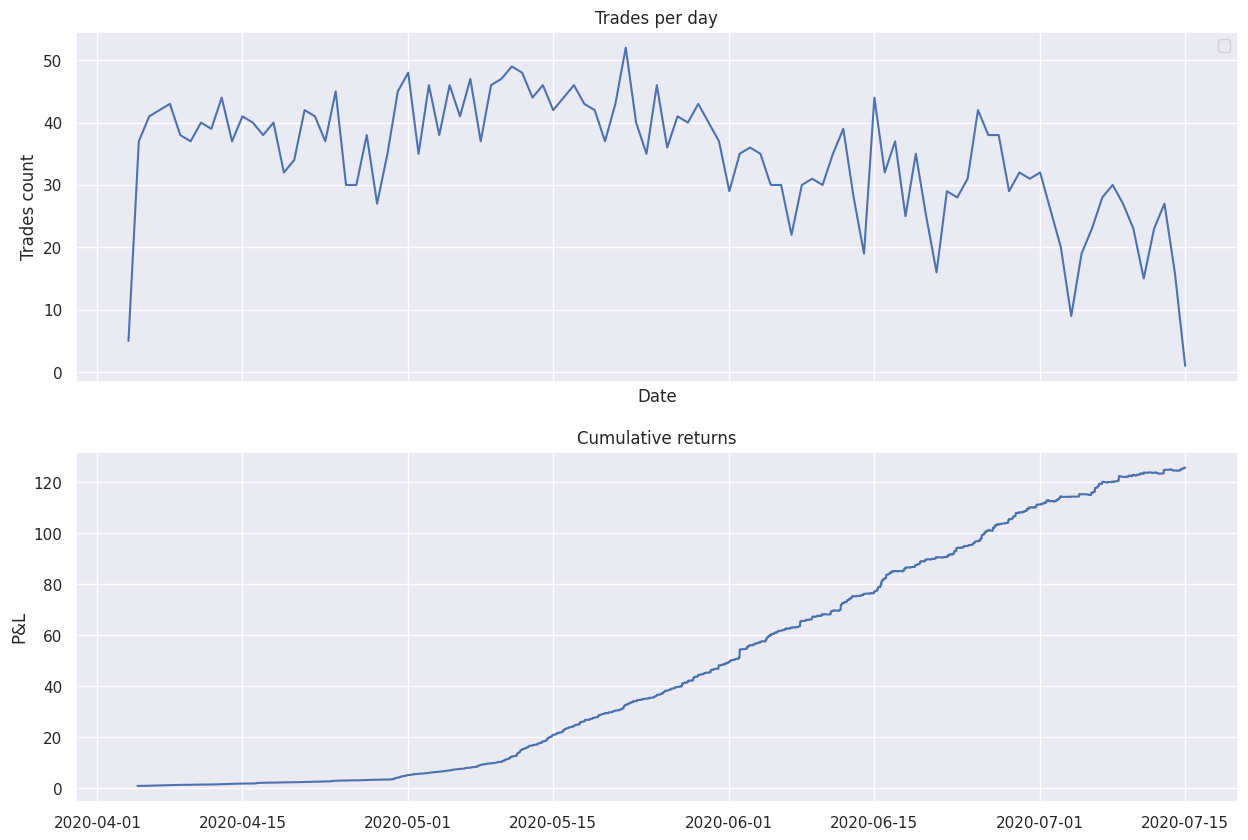

In [80]:
# with fee
df = backtest(df, 'signal', fee = 0.001)

In [154]:
features_name = df.columns.tolist()
features_name.remove('signal')
features_name.remove('future_delta1_midprice')
features_name.remove('returns')
features_name.remove('cum_returns')

In [155]:
features_name

['BTCUSDT',
 'rsi',
 'macd',
 'BBL_10_2.0',
 'BBM_10_2.0',
 'BBU_10_2.0',
 'BBB_10_2.0',
 'BBP_10_2.0',
 'BBL_50_2.0',
 'BBM_50_2.0',
 'BBU_50_2.0',
 'BBB_50_2.0',
 'BBP_50_2.0',
 'BBL_100_2.0',
 'BBM_100_2.0',
 'BBU_100_2.0',
 'BBB_100_2.0',
 'BBP_100_2.0',
 'ema10',
 'ema50',
 'ema100',
 'zscore10',
 'zscore50',
 'zscore100',
 'rvi']

In [156]:
train, test = train_test_split(df, test_size=0.3, shuffle=False)

In [157]:
X_train = train[features_name].values
y_train = train['signal'].values

In [158]:
X_test = test[features_name].values
y_test = test['signal'].values

In [159]:
clf = lgb.LGBMClassifier()
# learning_rate=0.005
clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 6780, number of used features: 25
[LightGBM] [Info] Start training from score -0.931899
[LightGBM] [Info] Start training from score -1.297711
[LightGBM] [Info] Start training from score -1.099498


LGBMClassifier()

In [160]:
# Посмотрим на распределение веса фичей
dict(zip(features_name, clf.feature_importances_))

{'BTCUSDT': 237,
 'rsi': 702,
 'macd': 537,
 'BBL_10_2.0': 237,
 'BBM_10_2.0': 166,
 'BBU_10_2.0': 237,
 'BBB_10_2.0': 764,
 'BBP_10_2.0': 908,
 'BBL_50_2.0': 284,
 'BBM_50_2.0': 120,
 'BBU_50_2.0': 253,
 'BBB_50_2.0': 596,
 'BBP_50_2.0': 445,
 'BBL_100_2.0': 293,
 'BBM_100_2.0': 216,
 'BBU_100_2.0': 219,
 'BBB_100_2.0': 668,
 'BBP_100_2.0': 535,
 'ema10': 93,
 'ema50': 113,
 'ema100': 168,
 'zscore10': 108,
 'zscore50': 150,
 'zscore100': 212,
 'rvi': 739}

In [161]:
y_pred=clf.predict(X_test)

In [162]:
pd.Series(y_pred).value_counts()

 1    1356
-1     904
 0     647
dtype: int64

In [168]:
y_pred_new = clf.predict_proba(X_test)

In [172]:
y_pred = pd.Series(y_pred * 0)
y_pred[y_pred_new[:,0] > np.quantile(y_pred_new[:,0], 0.88)] = -1
y_pred[y_pred_new[:,2] > np.quantile(y_pred_new[:,2], 0.9)] = 1
y_pred = y_pred.values
pd.Series(y_pred).value_counts()

 0    2267
-1     349
 1     291
dtype: int64

In [173]:
test['signal_pred'] = y_pred

Total trades count = 117
Max drawdown = 2.8367819557587826%
Average trades count per day = 3.774193548387097
Average return per day = 0.21332393929553162%
Average return per closing pos = 0.01955978813024932%


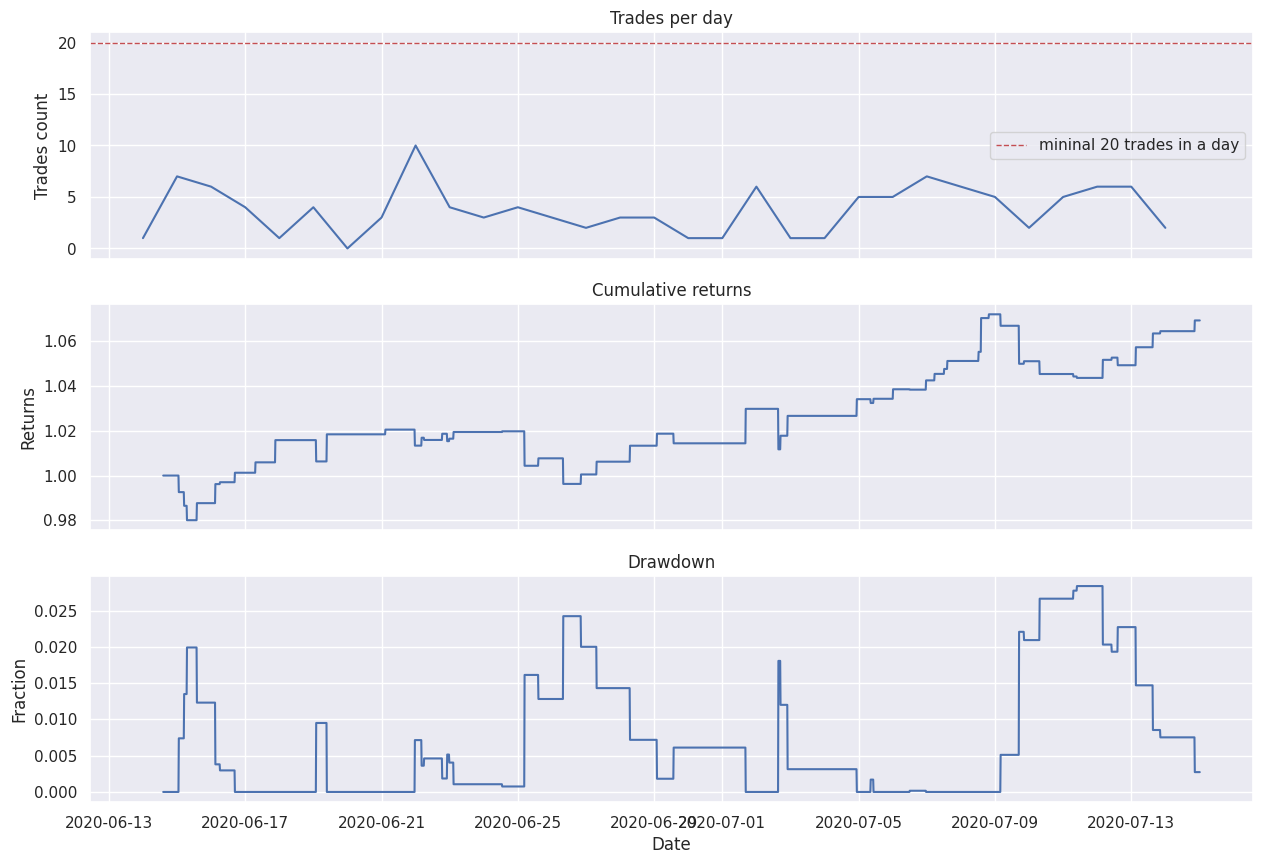

In [192]:
# without fee
test = backtest(test, 'signal_pred', fee=0.00)

Total trades count = 117
Max drawdown = 5.825737433682043%
Average trades count per day = 3.774193548387097
Average return per day = -0.14938938464374057%
Average return per closing pos = -0.013697594007448993%


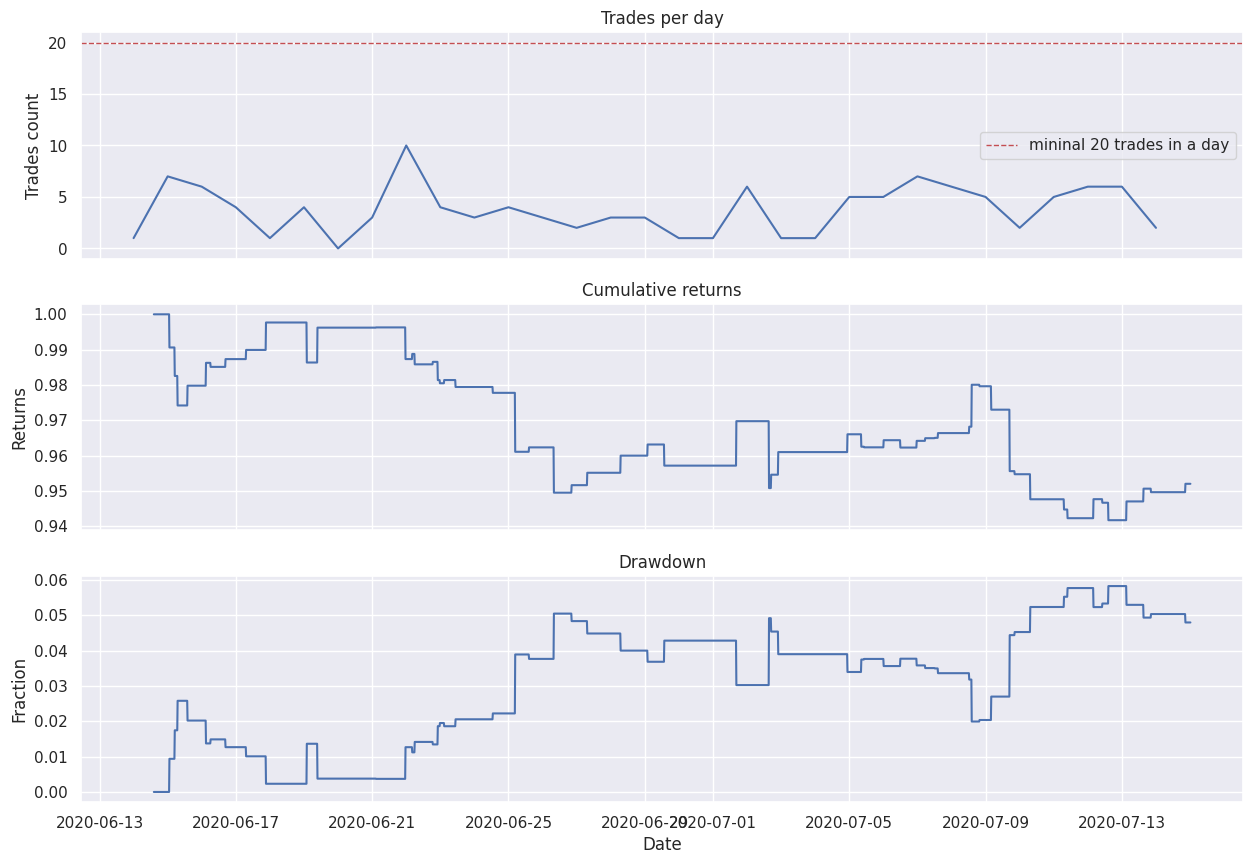

In [191]:
# with fee
test = backtest(test, 'signal_pred', fee=0.001)